In [1]:
import numpy as np
import collections
import os
import matplotlib.pyplot as plt

INFO_FIELDS = ['locus', 'rsid', 'qlpip', 'mcmcpip' , 'causality']
class PIPResult(collections.namedtuple('_PIPResult', INFO_FIELDS)):
    __slots__ = ()
    
def read_causal_rsids(causal_snps_file):
    causal_rsid = dict()
    with open(causal_snps_file, 'r') as mfile:
        locus_name = ''
        rsidlist = list()
        for mline in mfile:
            if not mline.startswith('#'):
                mline_split =  mline.split()
                if mline_split[0] == 'Locus':
                    #if len(rsidlist) > 0:
                    causal_rsid[locus_name] = rsidlist
                    locus_name = 'Locus.{:03d}'.format(int(mline_split[1].split(',')[0]))
                    rsidlist = list()
                else:
                    rsidlist.append(mline_split[0])
        #if len(rsidlist) > 0:
        causal_rsid[locus_name] = rsidlist
    return causal_rsid

In [2]:
def read_locusprefixes(locusfile):
    with open(locusfile, 'r') as mfile:
        locusprefixes = mfile.readlines()
    locusprefixes = [x.strip() for x in locusprefixes]
    return locusprefixes

In [45]:
nsim = 10
startsim = 301
#basedir='/mnt/storage/saikat/work/multivariate-gwas-bayesian-logistic-regression/quasi_laplace_gwas/results/mcmc_vs_qL'
basedir='/scratch/sbanerj/quasi_laplace_gwas/simulated_phenotype/mcmc_vs_qL'
blore_path = 'blore_100/meta_without_feature/zmax{:d}_mu{:s}_pi0.01_sig0.01/blore_meta_res/{:s}.gen.res'
probit_path = 'pimass/c{:d}_1e6_probit/output/{:s}.mcmc.txt'
zmax = 2
muvar = '0'

In [46]:
result = list()

for sim in range(startsim, startsim + nsim):
    
    simname = 'sim{:03d}'.format(sim)
    simdir = os.path.join(basedir, 'simulations', simname)
    
    locusfile = os.path.join(simdir, 'LOCUSNAMES.CAUSAL')
    locusprefixes = read_locusprefixes(locusfile)

    causal_snps_file = os.path.join(simdir, 'samples', 'causal.snplist')
    causal_rsids = read_causal_rsids(causal_snps_file)
                    

    for locus in locusprefixes:
        
        rsid_list = list()
        ql_pip = collections.defaultdict(lambda:0)
        mcmc_pip = collections.defaultdict(lambda:0)
        
        outfile = os.path.join( simdir, blore_path.format(zmax, muvar, locus) )
        with open(outfile, 'r') as mfile:
            for mline in mfile:
                mline_split = mline.split()
                if not mline_split[0] == 'Causal':
                    rsid = mline_split[0].strip()
                    ql_pip[rsid] = max(float(mline_split[4]), 1e-8)
                    if rsid not in rsid_list:
                        rsid_list.append(rsid)

        outfile = os.path.join( simdir, probit_path.format(zmax, locus) )
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                mline_split = mline.split()
                rsid = mline_split[0].strip()
                mcmc_pip[rsid] = max(float(mline_split[3]), 1e-8)
                if rsid not in rsid_list:
                    rsid_list.append(rsid)
                
        for rsid in rsid_list:
            causality = 1 if rsid in causal_rsids[locus] else 0
            mres = PIPResult(locus = locus,
                             rsid = rsid,
                             qlpip = ql_pip[rsid],
                             mcmcpip = mcmc_pip[rsid],
                             causality = causality)
            result.append(mres)

In [40]:
blore_true = [np.log10(x.qlpip)   for x in result if x.causality == 1]
bvsr_true  = [np.log10(x.mcmcpip) for x in result if x.causality == 1]

blore_false = [np.log10(x.qlpip)   for x in result if x.causality == 0]
bvsr_false  = [np.log10(x.mcmcpip) for x in result if x.causality == 0]

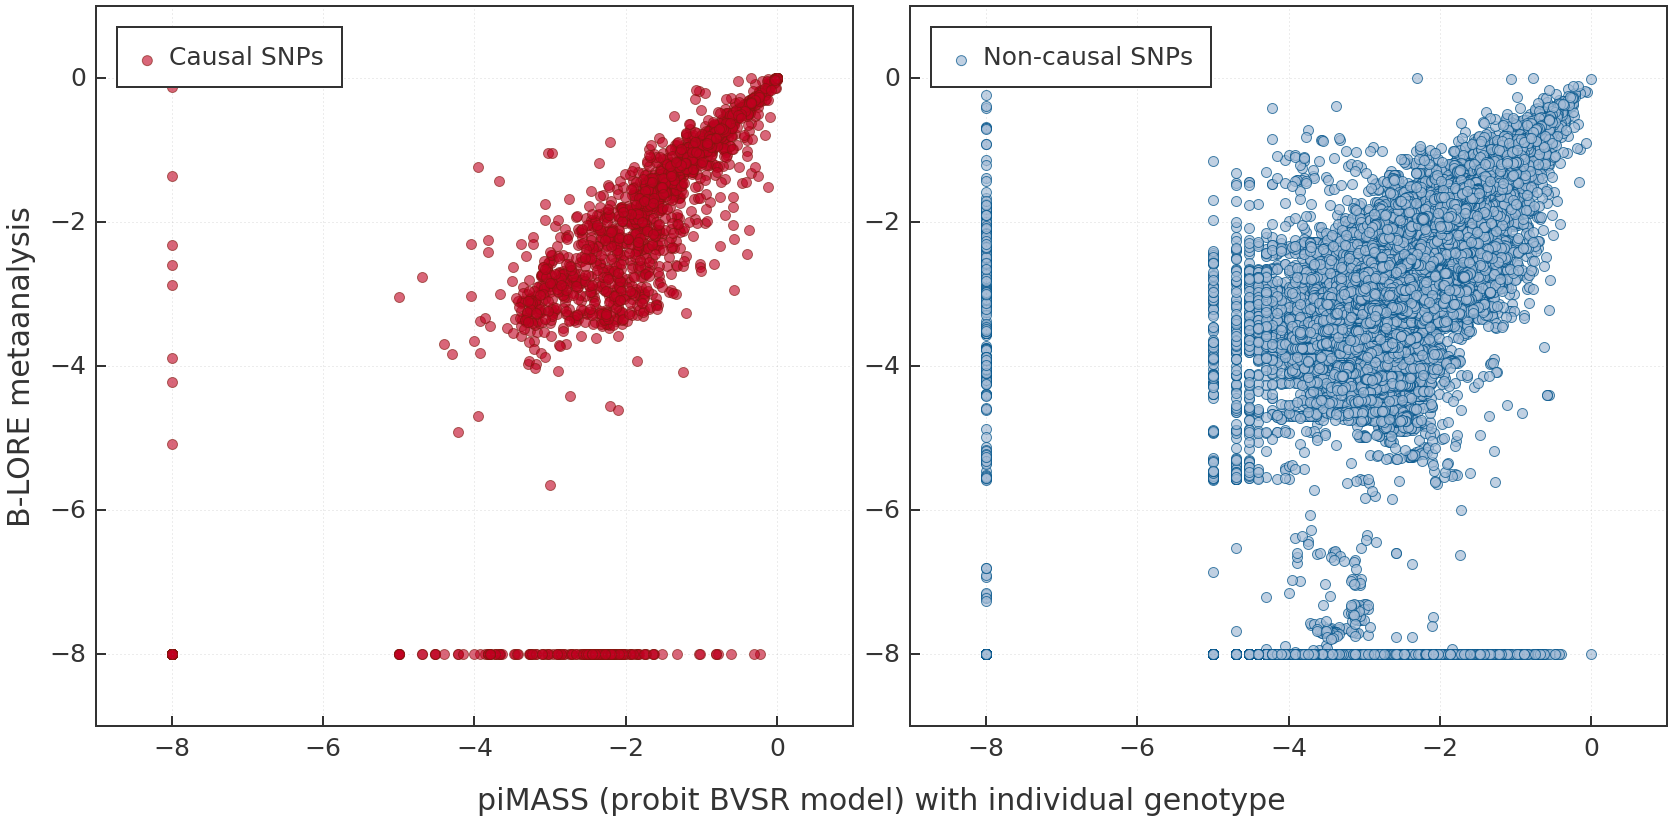

In [41]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
colors = kelly_colors_hex
figsize = (24, 12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = figsize)
ax0 = fig.add_subplot(111) # A big subplot for holding the axis labels
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)

mlabel = "Causal SNPs"
ax1.scatter(bvsr_true, blore_true, color=colors[4], edgecolor=colors[15], s = 100, alpha = 0.6, label = mlabel)
#ax1.plot([0,1], [0,1], lw=borderwidth, color=bordercolor)

mlabel = "Non-causal SNPs"
ax2.scatter(bvsr_false, blore_false, color=colors[3], edgecolor=colors[9], s = 100, alpha = 0.7, label = mlabel)
#ax2.plot([0,1], [0,1], lw=borderwidth, color=bordercolor)

mxlabel = r'piMASS (probit BVSR model) with individual genotype'
mylabel = r'B-LORE metaanalysis'

ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(axis='both', which='major',
                top='off', bottom='off', left='off', right='off',
                labelbottom='off', labelleft='off',
                pad=10, labelsize=label_font_size)
#x0.tick_params(top='off', bottom='off', left='off', right='off', pad=10, labelsize=label_font_size)
ax0.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 60)
ax0.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 60)


for ax in [ax1, ax2]:
    #ax.set_ylim(-0.02, 1.02)
    #ax.set_xlim(-0.02, 1.02)

    legendtitle = 'SNPs'
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                       scatterpoints = 1,
                       frameon = True, borderpad = 1.5, labelspacing = 1.5
                       #title = legendtitle
                      )
    lframe = legend.get_frame()
    lframe.set_edgecolor(bordercolor)
    lframe.set_linewidth(borderwidth)

    ax.tick_params(axis='both', which = 'major', 
                   length = 10, width = borderwidth, pad=10,
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = False
                  )
    for side, border in ax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)
    for fonts in ([legend.get_title()] + legend.texts):
        fonts.set_fontsize(legend_font_size)
        fonts.set_color(bordercolor)
    ax.grid(color='dimgray', lw=0.5, alpha=0.5)

plt.tight_layout()
#plt.savefig('pip_comparison_probit_mcmc_qL_muvar_bimodal.png', bbox_inches='tight')
#plt.savefig('pip_comparison_probit_mcmc_linear_mcmc_bimodal.pdf', bbox_inches='tight')
plt.show()

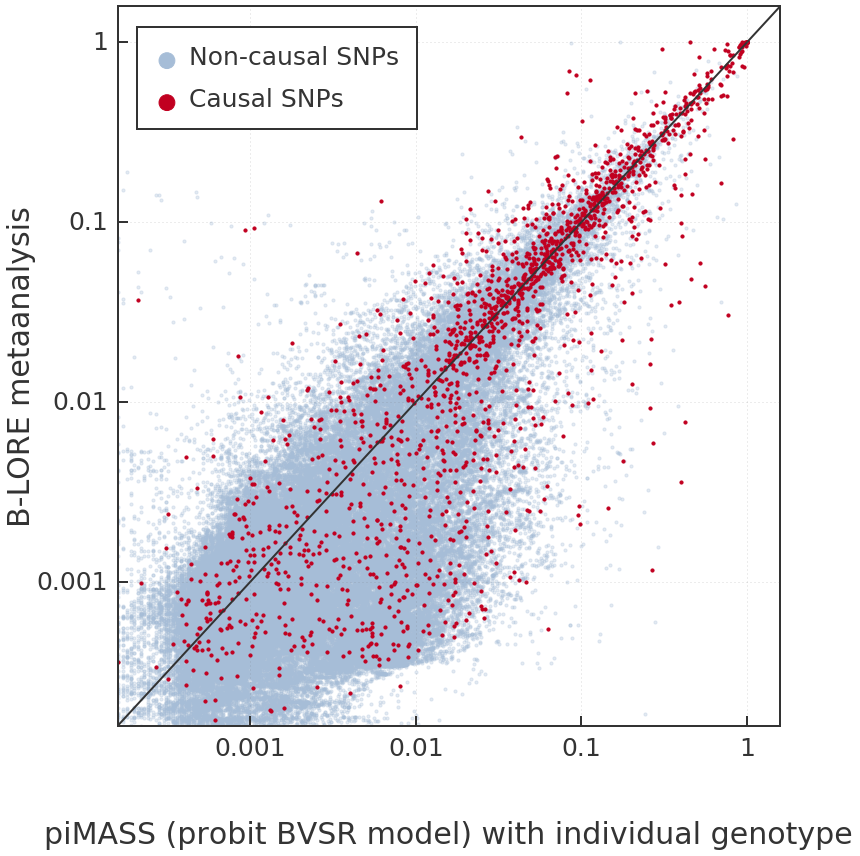

In [42]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
colors = ['#A6BDD7', '#C10020']
figsize = (12, 12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = figsize)
ax1 = fig.add_subplot(111)

mlabel = "Non-causal SNPs"
ax1.scatter(bvsr_false, blore_false, color=colors[0], s = 10, alpha = 0.3, label = mlabel)
ax1.plot([-6, 1], [-6, 1], lw=borderwidth, color=bordercolor)
mlabel = "Causal SNPs"
ax1.scatter(bvsr_true, blore_true, color=colors[1], s = 10, alpha = 1, label = mlabel)

ax1.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 60)
ax1.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 0)

for ax in [ax1]:
    ax.set_ylim(-3.8, 0.2)
    ax.set_xlim(-3.8, 0.2)
    mticks = [-3, -2, -1, 0]
    ax.set_xticks(mticks)
    ax.set_yticks(mticks)
    tl = ["{:g}".format(np.power(10.,x)) for x in mticks]
    ax.set_xticklabels(tl)
    ax.set_yticklabels(tl)

    legendtitle = 'SNPs'
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                       scatterpoints = 1,
                       markerscale=5,
                       frameon = True, borderpad = 1.5, labelspacing = 1.5
                       #title = legendtitle
                      )
    for l in legend.legendHandles:
        l.set_alpha(1)
    lframe = legend.get_frame()
    lframe.set_edgecolor(bordercolor)
    lframe.set_linewidth(borderwidth)

    ax.tick_params(axis='both', which = 'major',
                   length = 10, width = borderwidth, pad=10,
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = False
                  )
    for side, border in ax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)
    for fonts in ([legend.get_title()] + legend.texts):
        fonts.set_fontsize(legend_font_size)
        fonts.set_color(bordercolor)
    ax.grid(color='dimgray', lw=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('pip_normal_beta_probit_mcmc_qLmu0_h04.png', bbox_inches='tight')
#plt.savefig('pip_comparison_probit_mcmc_linear_mcmc_bimodal.pdf', bbox_inches='tight')
plt.show()

In [33]:
[x for x in result if x.qlpip == 1e-8 and x.causality == 1]

[PIPResult(locus='Locus.021', rsid='rs9392425', qlpip=1e-08, mcmcpip=0.00016, causality=1),
 PIPResult(locus='Locus.051', rsid='rs62057560', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.060', rsid='rs62136823', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.060', rsid='rs17481147', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.062', rsid='rs10939520', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.062', rsid='rs6823297', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.095', rsid='rs10770370', qlpip=1e-08, mcmcpip=1e-05, causality=1),
 PIPResult(locus='Locus.095', rsid='rs10841040', qlpip=1e-08, mcmcpip=0.00022, causality=1),
 PIPResult(locus='Locus.095', rsid='rs543384', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.095', rsid='rs11831012', qlpip=1e-08, mcmcpip=1e-08, causality=1),
 PIPResult(locus='Locus.111', rsid='rs3784283', qlpip=1e-08, mcmcpip=2e-05, causality=1),
